# Weather Changes Over Time (Consuming APIs)

## Task
Utilize the following two APIs to evaluate the changes in temperature for your birthdate and city you were born in:
* [geocode.xyz](geocode.xyz)
* [open-meteo.com](open-meteo.com)


In [2]:
from datetime import date, datetime, timedelta

import requests
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

sns.set_palette('muted')
sns.set_style('white')

## Question 1: Geocoding A Location

> Indented block


Write a function that utilizes the [geocode.xyz](geocode.xyz) API to take in a city and country and return the latitude and longitude of that location

```
def geocode_location(city, country):
    # your code
    return latitude, longitude
```

For example:
```
geocode_location("london", "united kingdom")
```
should return
```
(51.49742, -0.11534)
```

In [4]:
# write your solution here
def geocode_location(city, country):
    geocode_url = 'https://geocode.xyz'
    params = {'locate': f'{city}, {country}', 
             'json': 1 }
    r = requests.get(geocode_url, params)
    r = r.json()
    longitude = r['longt']
    lattitude = r['latt']
    return (lattitude, longitude)

geocode_location('York', 'United States')


('43.85779', '-79.48367')

## Question 2: Determining Weather Using Date and Location
Write a function that utilizes the [open-meteo.com](https://open-meteo.com/) API to take in a date and location and return the 15-day average high and low for the following measurements from the years 1960 to 2022:
* `precipitation_sum` (mm): Sum of daily precipitation (including rain, showers and snowfall)
* `temperature_2m_max` (°F): Maximum daily air temperature at 2 meters above ground
* `temperature_2m_min` (°F): Minimum daily air temperature at 2 meters above ground
* `apparent_temperature_max` (°F): Maximum daily apparent temperature
* `apparent_temperature_min` (°F): Min daily apparent temperature

The function should return the above measurements in a dictionary object with the keys being `"precipitation_sum"`, `"temperature_2m_max"`, etc. and the values being the 15-day average of the measurements. The 15-day average should be the 7 days preceeding the input date, the input date, and the 7 days following the input date. This will give the results more statistical validity by increasing the number of samples for each measurement.

The `get_historical_weather_measurements()` function will include a few different sub-tasks:

### Create API Request in Postman/Insomnia
Use the following [API Documentation](https://open-meteo.com/en/docs/historical-weather-api#api-documentation) page to create an API request that responds with a JSON object of the measurements listed above. Make sure the response object meets the following:
* Temperatue measurements are in Fahrenheit
* Precipitation measurements are in inches
* Measurements are daily aggregations
* 15 day range of weather
* JSON format

Before writing any code, use Postman/Insomnia to create the API request and take a screenshot of the request/response.

#### HINT: How to insert a screenshot
1. Take a screenshot and save it to a file.
2. Create a markdown cell in your notebook.
3. Insert the image into the markdown cell.
  * Option 1: Drag the image file into the markdown cell. This embeds the image data directly into your Jupyter notebook.
  * Option 2: Move the file into the directory with your notebook file (inside the project folder that you will submit). Add markdown to insert the image: `![alternative text](path-to-image)`

### Create API Request Function
Convert the request above into a function. The function should take in `latitude`, `longitude`, and `date` as its arguments and return the API response, if successful.

```
def get_api_response(latitude, longitude, date):
    # your code

```

Use the helper function below for creating a 15-day date range

Postman screenshot
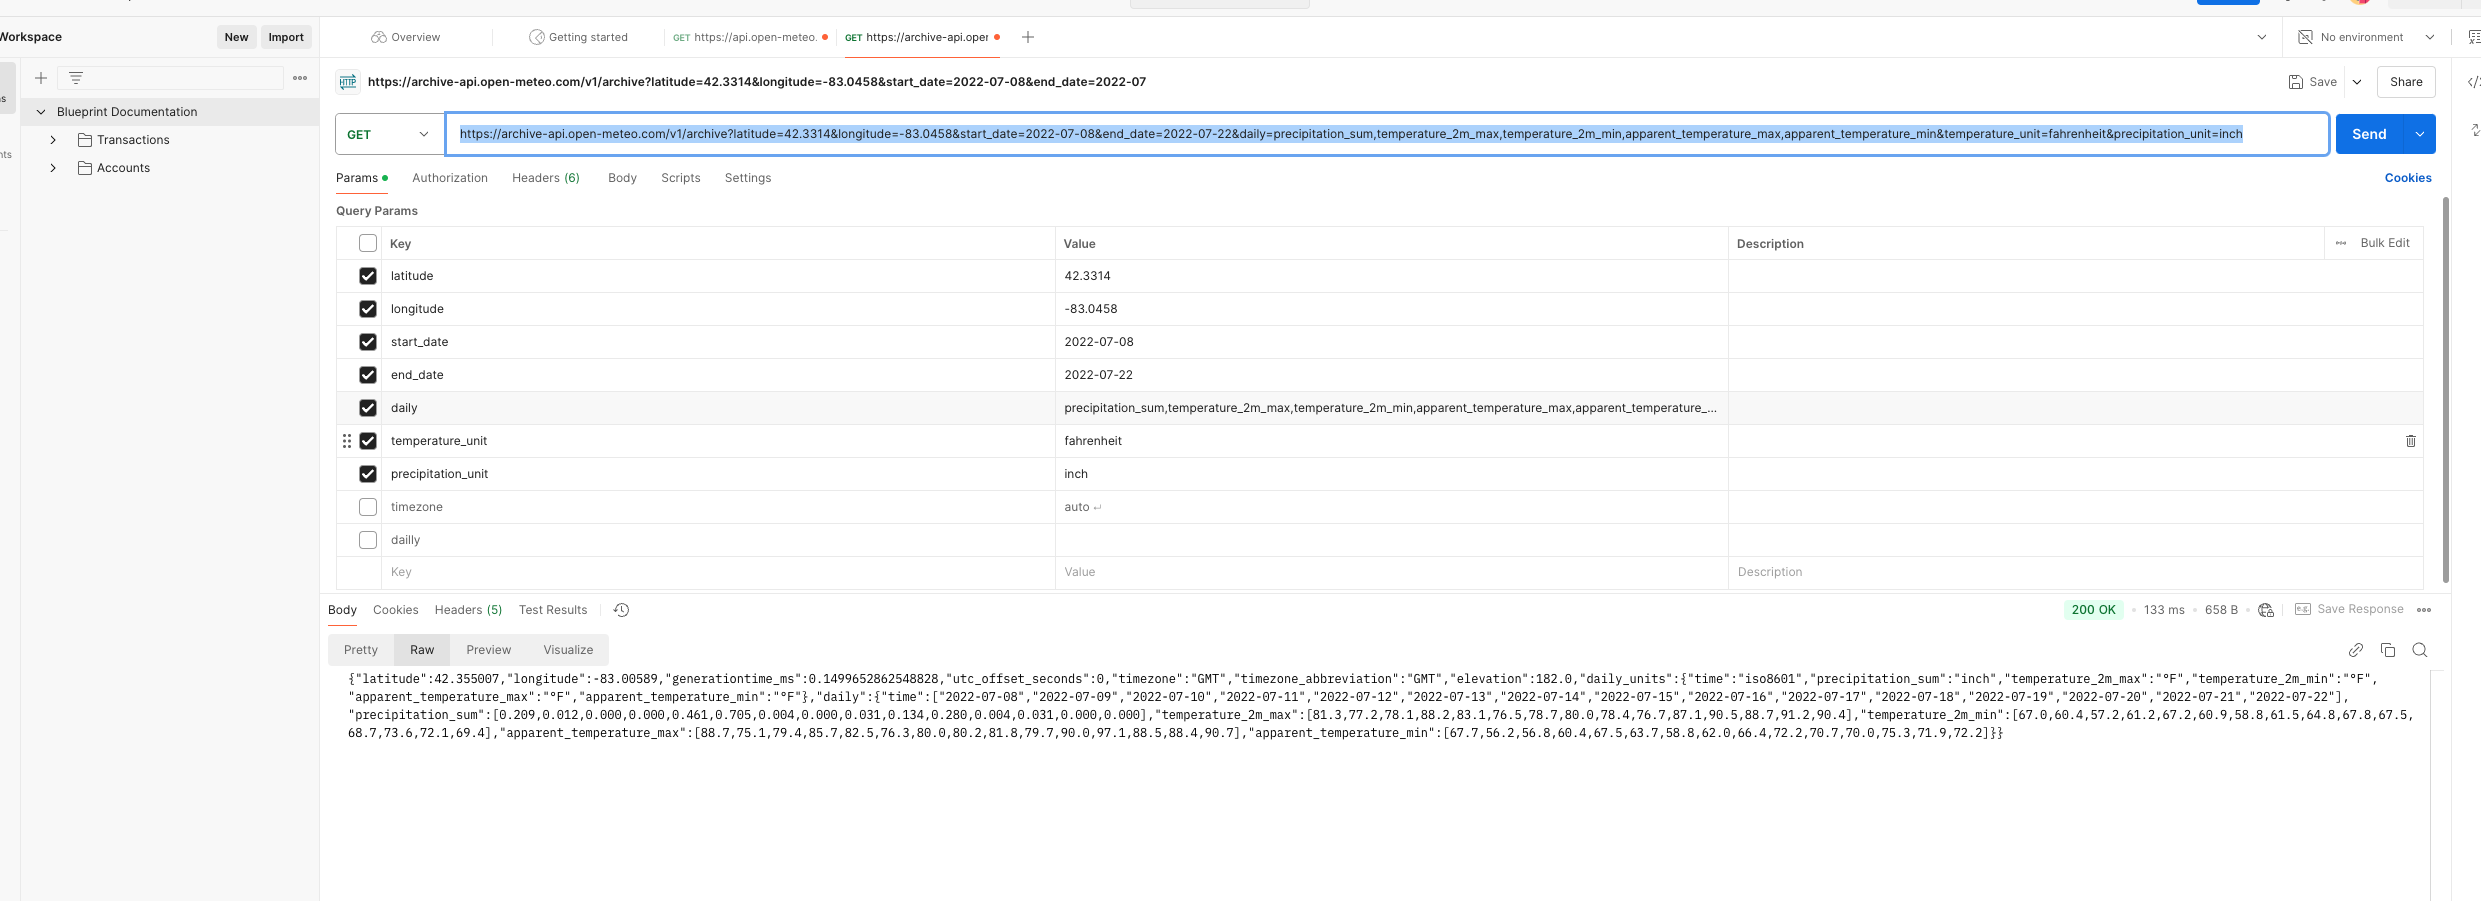

In [7]:
from datetime import timedelta

def get_15_day_date_range(target_date):
 
    start_date = target_date - timedelta(days=7)
    end_date = target_date + timedelta(days=7)
    return start_date, end_date


In [42]:
def get_api_response(latitude, longitude, request_date, birthdate):
    # Calculate 15-day date range
    start_date, end_date = get_15_day_date_range(request_date)

    # Base URL Open-Meteo API
    base_url = "https://archive-api.open-meteo.com/v1/archive"

    # API parameters
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date.isoformat(),  # Ensure start_date is a datetime.date object
        "end_date": end_date.isoformat(),      # Ensure end_date is a datetime.date object
        "daily": [
            "precipitation_sum",
            "temperature_2m_max",
            "temperature_2m_min",
            "apparent_temperature_max",
            "apparent_temperature_min"
        ],
        "temperature_unit": "fahrenheit",
        "precipitation_unit": "inch",
        "timezone": "auto"
    }

    # Make the API request
    response = requests.get(base_url, params=params)

    # Request if url was successful
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")
    
    return response.json()



### Iterating Over Each Year
Write a function that iterates through each year between 1960 and 2022 and returns the corresponding JSON response objects containing weather data for each year in a python list.

```
def get_all_response_objects(start_year, end_year):
    # your code
```


In [10]:
def get_all_response_objects(latitude, longitude, birthdate):
    """
    Fetch weather data for each year in the range 1960 to 2022.
    """
    responses = []
    for year in range(1960, 2023):  # Loop through the years 1960 to 2022
        # Create the request date using the year and birthdate's month/day
        request_date = datetime(year, birthdate.month, birthdate.day).date()
        
        # Pass `birthdate` to `get_api_response`
        response = get_api_response(latitude, longitude, request_date, birthdate)
        
        # Append the response to the list
        responses.append(response)
    
    return responses


# Parse JSON Responses & Aggregate Data
Write a function that takes the list of JSON response objects from the previous function in as a parameter and returns a pandas DataFrame containing the original input date, the measurements, and the average across the 15 days.
```
def parse_json_response(responses):
    # your code
```


In [12]:
# write your solution here
def parse_json_response(responses):
    df = pd.DataFrame(responses)
    df = df.join(pd.json_normalize(df['daily'])).drop(columns=['daily'])

#Get average of measurements
    measures = ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 'apparent_temperature_min', 
               'precipitation_sum']
    for col in measures:
        df[f'{col}_mean'] = df[col].apply(np.mean)

#add the year column
    df['year'] = df['time'].apply(lambda l: l[0][:4])

    return df[['year'] + [f'{measure}_mean' for measure in measures]]


In [13]:
# df = parse_json_response(responses)

### Combining the Functions
Write a function that combines all the above functions into one, where the user inputs their birthdate and location and the function returns the pandas DataFrame containing the summary of measurements.

```
def get_data():
    birthdate = get_user_birthdate()
    location = get_user_city_of_birth()
    # your code here
```

The helper functions below can be used for birthdate and location input information:

In [15]:
# helper functions
def get_user_birthdate():
    birthday = input('Enter your birthday (MM/DD/YYYY): ')
    return datetime.strptime(birthday, "%m/%d/%Y").date()

def get_user_city_of_birth():
    city = input('Enter the city you were born in: ')
    country = input('Enter the country you were born in: ')
    return city , country

In [16]:
# write your solution here
def get_data():
    birthdate = get_user_birthdate()
    location = get_user_city_of_birth()
    latitude, longitude = geocode_location(*location)
    responses = get_all_response_objects(latitude, longitude, birthdate)
    return parse_json_response(responses)

Run your function and set it equal to `df`:

In [18]:
df = get_data()

df.head()

Enter your birthday (MM/DD/YYYY):  12/06/1991
Enter the city you were born in:  Detroit
Enter the country you were born in:  US


,year,temperature_2m_max_mean,temperature_2m_min_mean,apparent_temperature_max_mean,apparent_temperature_min_mean,precipitation_sum_mean
0,1960,35.673333,23.806667,25.826667,12.640000,0.007667
1,1961,39.666667,27.740000,31.300000,18.700000,0.064267
2,1962,35.640000,21.986667,28.113333,12.880000,0.082467
3,1963,35.026667,24.713333,26.566667,15.600000,0.055467
4,1964,29.813333,18.760000,21.300000,9.406667,0.126533


In [19]:
df.tail()

,year,temperature_2m_max_mean,temperature_2m_min_mean,apparent_temperature_max_mean,apparent_temperature_min_mean,precipitation_sum_mean
58,2018,36.953333,23.606667,29.133333,15.533333,0.064067
59,2019,39.193333,28.360000,31.020000,19.833333,0.059600
60,2020,41.813333,29.340000,33.993333,20.906667,0.065600
61,2021,43.993333,27.786667,36.086667,19.626667,0.097867
62,2022,43.293333,29.573333,35.353333,21.173333,0.030267


## Question 3: Visualizing The Data
Plot the DataFrame using `matplotlib`/`seaborn` and write a short summary of your results.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   year                           63 non-null     object 
 1   temperature_2m_max_mean        63 non-null     float64
 2   temperature_2m_min_mean        63 non-null     float64
 3   apparent_temperature_max_mean  63 non-null     float64
 4   apparent_temperature_min_mean  63 non-null     float64
 5   precipitation_sum_mean         63 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.1+ KB


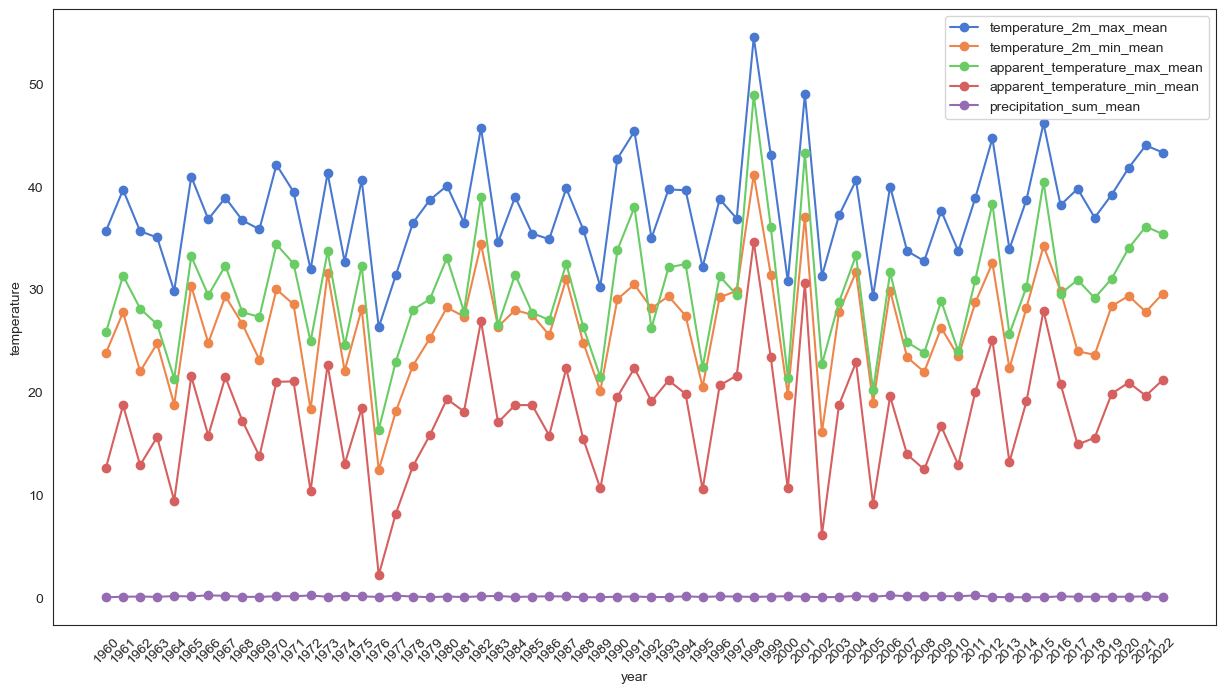

In [40]:
plt.figure(figsize=(15,8))
plt.plot(df['year'], df['temperature_2m_max_mean'], marker='o', label='temperature_2m_max_mean')
plt.plot(df['temperature_2m_min_mean'], marker='o', label='temperature_2m_min_mean')
plt.plot(df['apparent_temperature_max_mean'], marker='o', label='apparent_temperature_max_mean')
plt.plot(df['apparent_temperature_min_mean'], marker='o', label='apparent_temperature_min_mean')
plt.plot(df['precipitation_sum_mean'], marker='o', label='precipitation_sum_mean')
plt.xticks(rotation=45)
plt.xlabel('year')
plt.ylabel('temperature')
plt.legend()

### Results Summary:

From studying the histogram the results show that for all categories 1975 had some of the coldest year was 1975 and the warmest year was around 1997.